# HW 6
## Дедлайн: 15 декабря, 23:59

В этой домашке вам предстоит реализовать Wasserstain GAN и одну из её модификаций, а также разобраться с тем, как оценивать качество генеративных моделей

## Imports


In [1]:
import argparse
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, clear_output
from tqdm.notebook import tqdm
from typing import Optional
from torchsummary import summary

manualSeed = 111

random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()
device = 'cuda'
torch.cuda.set_device(0)

In [2]:
!nvidia-smi

Fri Dec 15 17:20:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  Off  | 00000000:05:00.0 Off |                  Off |
| N/A   34C    P0    64W / 350W |   1602MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM3...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   

In [3]:
import os


def reset_seed(seed=manualSeed):
    torch.manual_seed(seed)
    np.random.seed(seed)


os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Data Loading: CIFAR

In [45]:
!mkdir -p datasets

In [4]:
BATCH_SIZE = 128
CIFAR_MEAN, CIFAR_STD = (0.5,), (0.5,)

cifar_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ]
)
cifar_train_dataset = datasets.CIFAR10(
    train=True,
    root="datasets/cifar_train/",
    transform=cifar_transforms,
    download=True
)
cifar_train_loader = DataLoader(
    cifar_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
cifar_val_dataset = datasets.CIFAR10(
    train=False,
    root="datasets/cifar_val/",
    transform=cifar_transforms,
    download=True
)
cifar_val_loader = DataLoader(
    cifar_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Files already downloaded and verified
Files already downloaded and verified


### Plot data

In [5]:
def denorm(img_tensors, mean, std):
    return img_tensors * std + mean


def show_images(images, mean, std, nmax=25):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(
        vutils.make_grid(
            denorm(
                images.detach()[:nmax],
                mean,
                std
            ),
            nrow=8
        ).permute(1, 2, 0)
    )


def show_batch(dl, mean, std, nmax=25):
    for images, _ in dl:
        show_images(images, mean, std, nmax)
        break

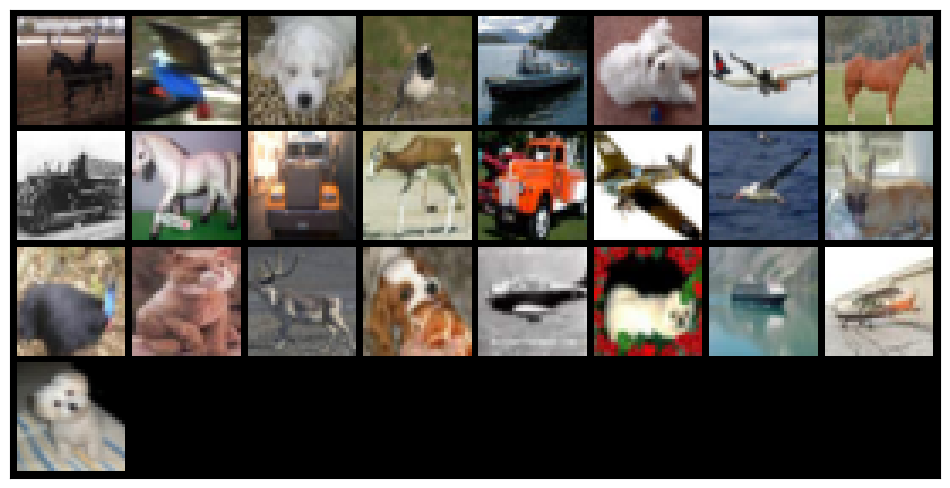

In [6]:
show_batch(cifar_train_loader, torch.Tensor(CIFAR_MEAN), torch.Tensor(CIFAR_STD))

## WGAN-GP (5 pt)

In [22]:
# do not change this function
def plot_losses(losses: np.ndarray, title: str):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel("Iterations", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

### WGAN

[WGAN](https://arxiv.org/abs/1701.07875) model uses weight clipping to enforce Lipschitzness of the discriminator.

The model objective is
$$
\min_{G} W(\pi || p) \approx \min_{G} \max_{\boldsymbol{\phi} \in \boldsymbol{\Phi}} \left[ \mathbb{E}_{\pi(\mathbf{x})} f_{\boldsymbol{\phi}}(\mathbf{x})  - \mathbb{E}_{p(\mathbf{z})} f_{\boldsymbol{\phi}}(G_{\boldsymbol{\theta}}(\mathbf{z}))\right].
$$
Here $f_{\boldsymbol{\phi}}(\mathbf{x})$ is the discriminator model. The discriminator weights $\boldsymbol{\phi}$ should lie in the compact set $\boldsymbol{\Phi} = [-c, c]^d$.

In [7]:
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
# New weights with accuracy 80.858%

class Discriminator(nn.Module):
    def __init__(self, n_channels: int, clip_c: Optional[float] = None):
        super().__init__()
        self.n_channels = n_channels
        self.clip_c = [x for x in clip_c]
        # sequence of convolutional layers and LeakyRelU -> reshape -> FC
        # conv_sequence and fc are separated due to the simple feature extraction,
        #     which will be used in the second task, FID
        #resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        resnet = resnet18()
        self.conv_sequence = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(self.n_channels, 1)
        

    def clip_weights(self) -> None:
        for layer in self.net:
            if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                # clip the weight to the range [-clip_c, clip_c]
                layer.weight.data = torch.clamp(layer.weight.data, min=self.clip_c[0], max=self.clip_c[1])

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # input.shape = (n_samples, 3, 32, 32)
        # output.shape = (n_samples, 1)
        out = self.get_features(input)
        out = self.fc(out)
        out = torch.sigmoid(out)
        return out

    def get_features(self, input: torch.Tensor) -> torch.Tensor:
        return self.conv_sequence(input).squeeze(-1).squeeze(-1)

In [8]:
class Generator(nn.Module):

    def __init__(self, n_channels=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.n_channels = n_channels
        
        self.gen = nn.Sequential(
            self.get_generator_block(n_channels, hidden_dim * 8, kernel_size=3, stride=2),
            self.get_generator_block(hidden_dim * 8, hidden_dim * 2, kernel_size=4, stride = 2),
            self.get_generator_block(hidden_dim * 2, hidden_dim, kernel_size=4, stride = 2,),
            self.get_generator_final_block(hidden_dim, im_chan, kernel_size=4, stride=2)
        )
        
    def get_generator_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True),
        ) 
    
    def get_generator_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 3):
        return  nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.Tanh()
            )
    
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # input.shape = (n_samples, self.input_size)
        # out.shape = (n_samples, 3, 32, 32)
        out = input.view(len(input), self.n_channels, 1, 1)
        out = self.gen(out)
        return out

    def sample(self, n_samples: int) -> torch.Tensor:
        # Generate random samples with shape (n_samples, self.input_size)
        # Apply forward pass to the array from the previous step
        noise = torch.randn(n_samples, self.n_channels, device=device)
        noise = noise.view(len(noise), self.n_channels, 1, 1)
        noisy_samples = self.gen(noise)
        return noisy_samples

In [10]:
disc = Discriminator(n_channels=512, clip_c=[-0.8, 0.8])
summary(disc)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-3              230,144
|    |    └─BasicBlock: 3-4              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-5              919,040
|    |    └─BasicBlock: 3-6              1,180,672
|    └─Sequential: 2-8                   --
|    |    └─BasicBlock: 3-7              3,673,088
|    |    └─BasicBlock: 3-8              4,720,640
|    └─AdaptiveAvgPool2d: 2-9            --
├─Linear: 1-2                            513
Total params: 11,177,025
Trainable params: 11,177,025
Non-trainabl

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              73,984
|    |    └─BasicBlock: 3-2              73,984
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-3              230,144
|    |    └─BasicBlock: 3-4              295,424
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-5              919,040
|    |    └─BasicBlock: 3-6              1,180,672
|    └─Sequential: 2-8                   --
|    |    └─BasicBlock: 3-7              3,673,088
|    |    └─BasicBlock: 3-8              4,720,640
|    └─AdaptiveAvgPool2d: 2-9            --
├─Linear: 1-2                            513
Total params: 11,177,025
Trainable params: 11,177,025
Non-trainabl

In [11]:
gen = Generator(n_channels=512, im_chan=3, hidden_dim=128).cuda()
a = gen.sample(100)
summary(gen)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─ConvTranspose2d: 3-1         4,719,616
|    |    └─BatchNorm2d: 3-2             2,048
|    |    └─ReLU: 3-3                    --
|    └─Sequential: 2-2                   --
|    |    └─ConvTranspose2d: 3-4         4,194,560
|    |    └─BatchNorm2d: 3-5             512
|    |    └─ReLU: 3-6                    --
|    └─Sequential: 2-3                   --
|    |    └─ConvTranspose2d: 3-7         524,416
|    |    └─BatchNorm2d: 3-8             256
|    |    └─ReLU: 3-9                    --
|    └─Sequential: 2-4                   --
|    |    └─ConvTranspose2d: 3-10        6,147
|    |    └─Tanh: 3-11                   --
Total params: 9,447,555
Trainable params: 9,447,555
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─ConvTranspose2d: 3-1         4,719,616
|    |    └─BatchNorm2d: 3-2             2,048
|    |    └─ReLU: 3-3                    --
|    └─Sequential: 2-2                   --
|    |    └─ConvTranspose2d: 3-4         4,194,560
|    |    └─BatchNorm2d: 3-5             512
|    |    └─ReLU: 3-6                    --
|    └─Sequential: 2-3                   --
|    |    └─ConvTranspose2d: 3-7         524,416
|    |    └─BatchNorm2d: 3-8             256
|    |    └─ReLU: 3-9                    --
|    └─Sequential: 2-4                   --
|    |    └─ConvTranspose2d: 3-10        6,147
|    |    └─Tanh: 3-11                   --
Total params: 9,447,555
Trainable params: 9,447,555
Non-trainable params: 0

### Gradient Penalty

[WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf)  model uses gradient penalty to enforce Lipschitzness.

The model objective is
$$
    W(\pi || p) = \underbrace{\mathbb{E}_{\pi(\mathbf{x})} f_{\boldsymbol{\phi}}(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x} | \boldsymbol{\theta})} f_{\boldsymbol{\phi}}(\mathbf{x})}_{\text{original critic loss}} + \lambda \underbrace{\mathbb{E}_{U[0, 1]} \left[ \left( \| \nabla_{\hat{\mathbf{x}}} f_{\boldsymbol{\phi}}(\hat{\mathbf{x}}) \|_2 - 1 \right) ^ 2\right]}_{\text{gradient penalty}},
$$
where the samples $\hat{\mathbf{x}}_\alpha = \alpha \mathbf{x} + (1 - \alpha) \mathbf{y}$ with $\alpha \in [0, 1]$ are uniformly sampled along straight lines between pairs of points: $\mathbf{x}$ from the data distribution $\pi(\mathbf{x})$ and $\mathbf{y}$ from the generator distribution $p(\mathbf{x} | \boldsymbol{\theta}))$.

In [12]:
def calculate_gradient_penalty(model, real_images, fake_images, device='cuda'):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake data

    alpha = torch.rand(real_images.shape[0], *([1] * (len(real_images.shape) - 1)), dtype=torch.float32, device=device)    
    
    # Get random interpolation between real and fake data
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)

    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty


def test_gradient_penalty():
    x = np.random.normal(size=(10, 4))
    x_norm = np.mean(np.sqrt(x**2))
    x = torch.randn(size=(10, 4)).cuda()
    x.requires_grad = True
    assert calculate_gradient_penalty(lambda x: x, x, x).cpu().numpy() == 1
    assert calculate_gradient_penalty(lambda x: x * 0, x, x).cpu().numpy() == 1

test_gradient_penalty()

The training loop

In [13]:
def train_wgan(
    generator: object,
    discriminator: object,
    train_loader: object,
    disc_steps: int,
    batch_size: int,
    n_epochs: int,
    lr: float,
    use_cuda: bool = True,
    gp_weight: Optional[float] = None,
) -> dict:

    if use_cuda:
        discriminator = discriminator.cuda()
        generator = generator.cuda()

    discriminator.train()
    generator.train()

    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.99, 0.999))
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.99, 0.999))

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1).cuda(), torch.zeros(1).cuda()
    batch_loss_history = {"discriminator_losses": [], "generator_losses": []}

    for epoch_i in tqdm(range(n_epochs)):
        for batch_i, (x, _) in enumerate(train_loader):
            d_loss, g_loss = torch.zeros(1).cuda(), torch.zeros(1).cuda()
            curr_iter += 1
            x = x.cuda()

            # Update discriminator weights
            # D(x_fake) - D(x_real)
            disc_optimizer.zero_grad()
            fake_data = generator.sample(x.size()[0])
            d_loss += discriminator(fake_data).mean()- discriminator(x).mean()

            if gp_weight is not None:
                gp = calculate_gradient_penalty(discriminator, x, fake_data)
                d_loss += gp_weight * gp

            d_loss.backward()
            disc_optimizer.step()

            # generator update
            if curr_iter % disc_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                # -D(x_fake)
                g_loss += -discriminator(fake_data).mean()

                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history["generator_losses"].append(g_loss.data.cpu().numpy())
                batch_loss_history["discriminator_losses"].append(
                    d_loss.data.cpu().numpy()
                )

    return batch_loss_history

  0%|          | 0/40 [00:00<?, ?it/s]

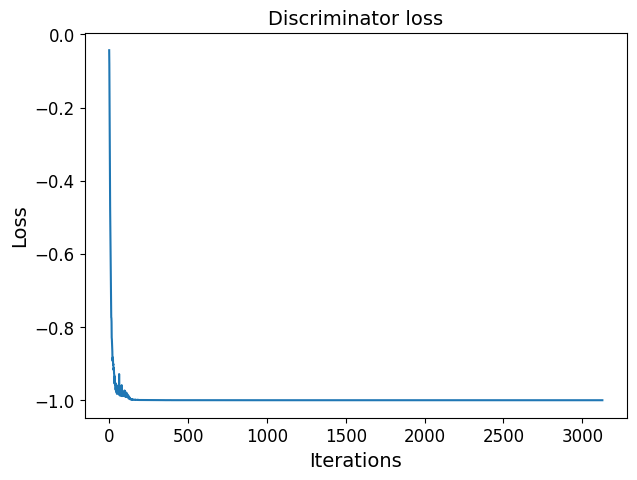

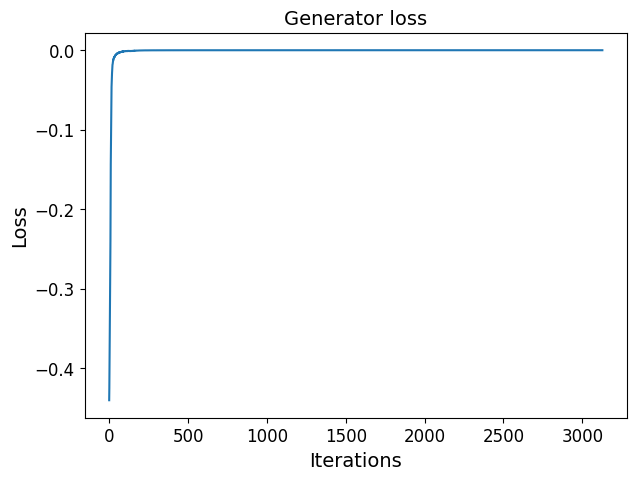

In [16]:
# choose these parameters (you have to train the model more than 20 epochs to get good results)
N_CHANNELS = 512  # > 32
N_EPOCHS = 40     # > 10
DISC_STEPS = 5  # > 2
CLIP_C =  [-0.8, 0.8]       # < 1
LR =  1e-4           # < 1e-3
# ====

generator = Generator(n_channels=N_CHANNELS, im_chan=3, hidden_dim=128)
discriminator = Discriminator(n_channels=N_CHANNELS, clip_c=CLIP_C)

train_losses = train_wgan(
    generator,
    discriminator,
    cifar_train_loader,
    disc_steps=DISC_STEPS,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    lr=LR,
    use_cuda=USE_CUDA,
)

plot_losses(train_losses["discriminator_losses"], "Discriminator loss")
plot_losses(train_losses["generator_losses"], "Generator loss")

Не забудьте сохранить обученную модель! Она пригодится в следующем пункте

In [23]:
torch.save(generator.state_dict(), './generator_.pth')
torch.save(discriminator.state_dict(), './discriminator_.pth')

## Метрики качества (5 pt)

Здесь вам предстоит оценить качество изображений, сгенерированных обученным ранее ГАНом.

In [70]:
generator = Generator(n_channels=N_CHANNELS, im_chan=3, hidden_dim=128)
discriminator = Discriminator(n_channels=N_CHANNELS, clip_c=CLIP_C)

generator.load_state_dict(torch.load('./generator_.pth'))
generator.eval()
generator.cuda()
discriminator.load_state_dict(torch.load('./discriminator_.pth'))
discriminator.eval()
discriminator.cuda()

Discriminator(
  (conv_sequence): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

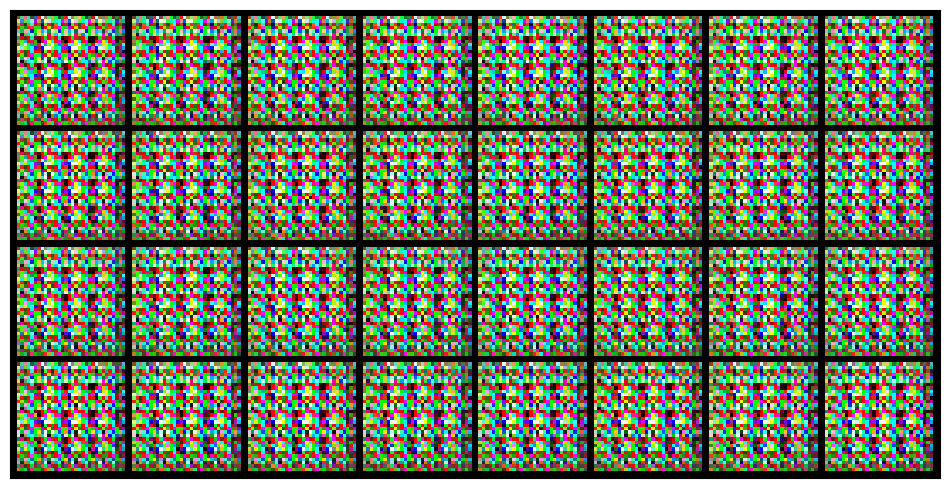

In [18]:
generator.eval()
discriminator.eval()
images = generator.sample(32)

show_images(images.cpu().detach(), torch.Tensor(CIFAR_MEAN), torch.Tensor(CIFAR_STD), nmax=32)

### Выводы:

Ну похоже нужно обучать дольше 60 эпох, и вообще, видимо, как-то по другому, но у меня уже ничего не выходит нового.

### 1. Визуализация распределений (1 pt)

Воспользуйтесь методом, снижающим размерность (TSNE, UMAP, PCA, ...) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи.

Дайте комментарий получившимся результатам

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# !pip install umap-learn + from umap import UMAP
real_images = torch.tensor(cifar_train_dataset.data[:]).reshape((1000, -1))
real_images_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(real_images)
fake_images = generator.sample(1000)
fake_images_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(fake_images.reshape(1000, -1).cpu().detach().numpy())

[]

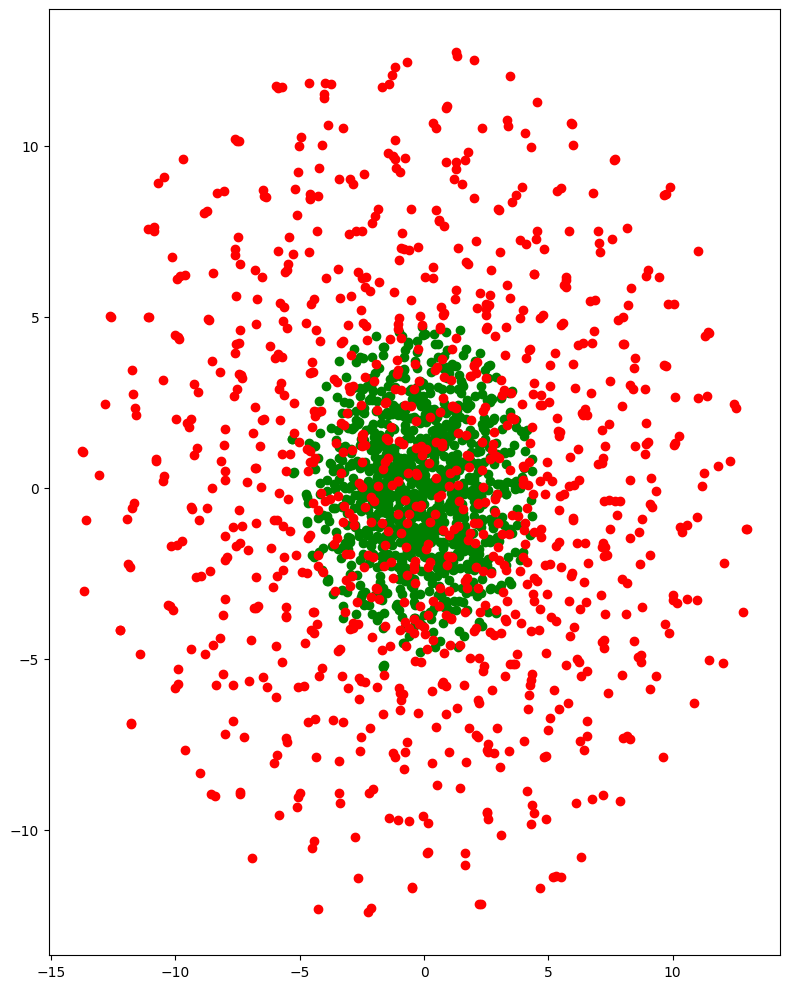

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10), tight_layout=True)
ax.scatter(x=real_images_tsne[:, 0], y=real_images_tsne[:, 1], c='green', label='Real images')
ax.scatter(x=fake_images_tsne[:, 0], y=fake_images_tsne[:, 1], c='red', label = 'Generated images')
plt.plot()

### Выводы:

Ну тут тоже видно, что не всё так хорошо, и мы не приближаем даже близко наши исходные картинки
Но вообще стало получше, чем было, если добавить сигмойду на конец в дискриминаторе.

### 2. Leave-One-Out 1NN Classifier (2 pt)

Идея подхода такова:
- сгенерировать $n$ фейковых изображений, взять $n$ настоящих из обучающей выборке; присвоить фейковым изображениям класс 0, настоящим – класс 1.
- обучить 1NN Classifier предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет sklearn.model_selection.LeaveOneOut


Каково идеальное значение метрики?
Каким вышел результат вашей модели?

In [26]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

n_samples = 500
fake_images = np.array(generator.sample(n_samples).reshape(n_samples, -1).detach().cpu())
real_images = np.array(cifar_train_dataset.data.reshape(50000, -1))[np.random.choice(50000, n_samples, replace=False)]

In [27]:
concat_data = np.concatenate((real_images, fake_images), axis=0)
answers = np.array([1 if i < n_samples else 0 for i in range(2*n_samples)])
shuffle = np.random.choice(2*n_samples, 2*n_samples, replace=False)
concat_data = concat_data[shuffle]
answers = answers[shuffle]

In [28]:
neigh = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()
acc_hist = []
for i, (train_index, test_index) in tqdm(enumerate(loo.split(concat_data))):
    neigh.fit(concat_data[train_index], answers[train_index])
    acc_hist.append(accuracy_score(answers[test_index], neigh.predict(concat_data[test_index])))

print(f"Accuracy = {np.array(acc_hist).mean():.3f}")

0it [00:00, ?it/s]

Accuracy = 1.000


### Вывод:
Ну очевидно, почему так вышло, можно посмотреть на картинки и всё станет понятно, другие методы можно даже не перебирать.

### 3. Frechet Inception Distance (FID) (2 pt)

$$
	\text{FID} (\pi, p) = \| \mathbf{m}_{\pi} - \mathbf{m}_{p}\|_2^2 + \text{Tr} \left( \boldsymbol{\Sigma}_{\pi} + \boldsymbol{\Sigma}_p - 2 \sqrt{\boldsymbol{\Sigma}_{\pi} \boldsymbol{\Sigma}_p} \right)
$$

* $\mathbf{m}_{\pi}$, $\boldsymbol{\Sigma}_{\pi} $ вектор среднего и ковариационная матрица признакового представления сэмплов из $\pi(\mathbf{x})$
* $\mathbf{m}_{p}$, $\boldsymbol{\Sigma}_p$ вектор среднего и ковариационная матрица признакового представления сэмплов из  $p(\mathbf{x} | \boldsymbol{\theta})$.

Для начала реализуем функцию подсчёта расстояния Фреше

In [29]:
# Helper function
import scipy
def get_matrix_sqrt(x: torch.Tensor) -> torch.Tensor:
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    if not np.isfinite(y).all():
        print("bad!")
    return torch.Tensor(y.real).cuda()

In [33]:
def get_distance(
    mu_x: torch.Tensor, mu_y: torch.Tensor, sigma_x: torch.Tensor, sigma_y: torch.Tensor
) -> torch.Tensor:
    return torch.norm(mu_x -mu_y, 2)**2 + torch.trace(sigma_x + sigma_y - 2*get_matrix_sqrt(sigma_x@sigma_y))

def test_get_distance():
    mu_x = torch.ones(3)
    mu_y = torch.ones(3) * 10
    sigma_x = torch.eye(3) * 5
    sigma_y = torch.eye(3) * 3
    dist = get_distance(mu_x.cuda(), mu_y.cuda(), sigma_x.cuda(), sigma_y.cuda()).cpu()
    assert np.isclose(dist, 243.7621)

test_get_distance()

Далее реализуем функцию вычисления промежуточных представлений настоящих и сгенерированных изображений

Для генерации признаков воспользуйтесь методом `get_features` из класса `Discriminator`

In [34]:
def get_features(
    generator: object,
    discriminator: object,
    loader: object,
    n_samples: int,
    batch_size: int,
) -> tuple:
    if USE_CUDA:
        generator = generator.cuda()
        discriminator.cuda()

    generator.eval()
    discriminator.eval()

    fake_features_list = []
    real_features_list = []
    cur_samples = 0

    with torch.no_grad():
        for real_samples in loader:
            if USE_CUDA:
                real_samples = real_samples.cuda()
            # get features of real samples
            real_features = discrininator.get_features(real_samples)
            real_features_list.append(real_features)

            fake_samples = generator.sample(len(real_samples), step=3)
            if USE_CUDA:
                fake_samples = fake_samples.cuda()

            # get features of fake samples
            fake_features = discrininator.get_features(fake_samples)
            fake_features_list.append(fake_features)

            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break

    fake_features_all = torch.cat(fake_features_list)
    real_features_all = torch.cat(real_features_list)
    return fake_features_all, real_features_all

Теперь вы готовы реализовать основную функцию подсчёта FID

In [35]:
def get_frechet_inception_distance(
    generator: object,
    discriminator: object,
    loader: object,
    n_samples: int,
    batch_size: int,
) -> torch.Tensor:
    # 1) get features
    # 2) calculate stats
    # 3) get distance
    all_activations = []
    
    for i, (real_images, _) in enumerate(loader):
        if i * batch_size >= n_samples:
            real_activations = torch.cat(all_activations, dim=0)[:n_samples]
            break
        real_images = real_images.cuda()
        all_activations.append(discriminator.get_features(real_images))
    
    fake_images = generator.sample(n_samples).cuda()
    fake_activations = discriminator.get_features(fake_images)
    
    mu_real, sigma_real = torch.mean(real_activations, dim=0), torch.cov(real_activations)
    mu_fake, sigma_fake = torch.mean(fake_activations, dim=0), torch.cov(fake_activations)
    mu_real, mu_fake, sigma_real, sigma_fake = mu_real.cuda(), mu_fake.cuda(), sigma_real.cuda(), sigma_fake.cuda() 
          #mu_x: torch.Tensor, mu_y: torch.Tensor, sigma_x: torch.Tensor, sigma_y: torch.Tensor
    fid = get_distance(mu_real, mu_fake, sigma_real, sigma_fake)
    
    return fid.item()

А теперь посчитайте FID на валидационном датасете

In [36]:
torch.cuda.empty_cache()

In [37]:
N_SAMPLES = 1000

reset_seed()

fid = get_frechet_inception_distance(
    generator,
    discriminator,
    loader=cifar_val_loader,
    n_samples=N_SAMPLES,
    batch_size=BATCH_SIZE,
)
print(fid)

1351.205078125


### Вывод:
Исскуством обучения ганов я пока не овладел, надо как-то поумнее подбирать параметры, да и график обучения выглядит не нормально, по сравнению с тем, что рисуют в интернетах, но что есть, то есть.

Архитектуры пробовались разные, были попробованы предобученный resnet50, resnet18, они же, но не обученные, был попробован генератор с количеством параметров в 3 раза больше, чем дискриминатора, наоборот тоже было попбровано, в первой версии использовался rmsprop, потом я поменял на адам в надежде, что сходимость улучшится, но ничего не вышло, возможно, нужно поставить sgd и забыть об этом на день, этот вариант не был попробован.

Из гипотез почему так, я составил следующий список:

0. Багулина в коде, которую я не замечаю.
1. Подбор архитектуры это искусство, и я им не владею.
2. Более сложный процесс обучения, есть какие-то эвристики, которых я не знаю.

В этой версии была добавлена сигмойда в дискриминаторе, но она не решила проблемы, предикты всё такие же рандомные квадратики.
Также уменьшился fid c 4000 до 1300, что наверное о чем-то говорит, что ещё n-ое количество эпох и рестартов и может стать нормально.